In [ ]:
# 위 작업 일괄 처리 (파일 압축 해제)

%%bash

rm -rf sample_data/dogs-vs-cats
rm -rf sample_data/dogs-vs-cats2

cp drive/MyDrive/Colab\ Notebooks/data-files/dogs-vs-cats.zip sample_data/
unzip sample_data/dogs-vs-cats.zip -d sample_data/

unzip sample_data/dogs-vs-cats/train.zip -d sample_data/dogs-vs-cats
unzip sample_data/dogs-vs-cats/test1.zip -d sample_data/dogs-vs-cats
mv sample_data/dogs-vs-cats/test1 sample_data/dogs-vs-cats/test

rm -rf sample_data/__MACOSX

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as tf_keras

In [3]:
# 데이터 디렉터리 구성
# train_dir, test_dir, validation_dir # 훈련, 테스트, 검증 세트 폴드
# train_dir -> cats, dogs # 범주로 사용될 폴더
# test_dir -> cats, dogs
# validation_dir -> cats, dogs

import os, shutil

src_base = 'sample_data/dogs-vs-cats'
dest_base = 'sample_data/dogs-vs-cats2'

if os.path.exists(dest_base): # 이미 존재하는 폴더라면
  shutil.rmtree(dest_base)    # 폴더 제거 후
os.makedirs(dest_base)        # 새로 폴더 만들기

# train 폴더의 0 ~ 1000 : trainset,  1000 ~ 1500 : validationset, 1500 ~ 2000 : testset
for start, stop, path in zip([0, 1000, 1500], [1000, 1500, 2000], ['train', 'validation', 'test']):
  os.mkdir(os.path.join(dest_base, path)) # train or validation or test 폴더 생성
  for sub_path in ['cat', 'dog']:
    os.mkdir(os.path.join(dest_base, path, sub_path)) # train, validation, test 하위에 cats or dog 폴더 생성
    for idx in np.arange(start, stop):
      fname = f'{sub_path}.{idx}.jpg'
      shutil.copy(os.path.join(src_base, 'train', fname), os.path.join(dest_base, path, sub_path, fname))

In [4]:
# 디렉터리 구성 결과 확인
for path in ['train', 'test', 'validation']:
  for subpath in ['dog', 'cat']:
    print(path, '/', subpath, ':', len(os.listdir(f'sample_data/dogs-vs-cats2/{path}/{subpath}')))

train / dog : 1000
train / cat : 1000
test / dog : 500
test / cat : 500
validation / dog : 500
validation / cat : 500


In [5]:
# 입력 자동화 도구 만들기

# 특정 디렉터리의 파일을 읽어서 모델의 입력데이터로 변환하는 도구
train_generator = tf_keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_generator = tf_keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_generator = tf_keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [6]:
# 입력 데이터 구성

datasets = []
for path, generator in zip( ['train', 'test', 'validation'],
                            [train_generator, test_generator, validation_generator]):
  dataset = generator.flow_from_directory(directory=f'sample_data/dogs-vs-cats2/{path}',
                                          target_size=(256, 256),
                                          batch_size=32,
                                          class_mode="binary")
  datasets.append(dataset)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [47]:
augmentation_model = tf_keras.Sequential()
augmentation_model.add(tf_keras.layers.RandomFlip('horizontal'))
augmentation_model.add(tf_keras.layers.RandomRotation(0.1))
augmentation_model.add(tf_keras.layers.RandomZoom(0.2))

In [38]:
for dataset in datasets[0]:
  print( dataset[0][0].shape)
  break

(256, 256, 3)


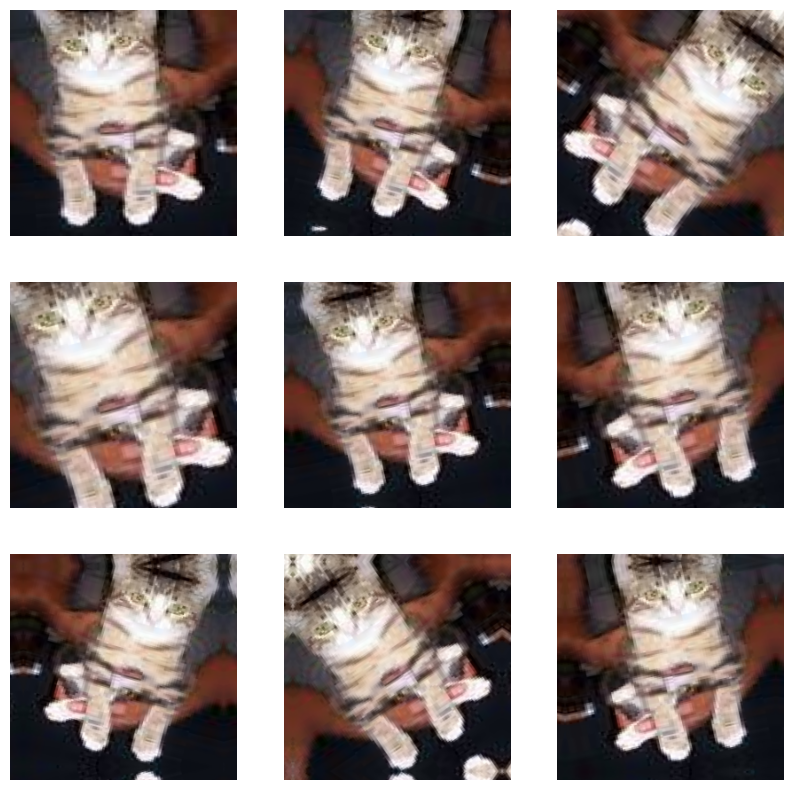

In [41]:
plt.figure(figsize=(10, 10))
for dataset in datasets[0]:
  images, labels = dataset
  for i in range(9):
    aug_image = augmentation_model(images[0])
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(aug_image)
    ax.axis('off')
  plt.show()
  break

In [56]:
# 모델 구조 설계

input = tf_keras.layers.Input(shape=(256, 256, 3))
x = augmentation_model(input)
x = tf_keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = tf_keras.layers.MaxPooling2D(2, 2)(x)
x = tf_keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = tf_keras.layers.MaxPooling2D(2, 2)(x)
x = tf_keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = tf_keras.layers.MaxPooling2D(2, 2)(x)

x = tf_keras.layers.Flatten()(x)

x = tf_keras.layers.Dense(256, activation='relu')(x)
x = tf_keras.layers.Dropout(0.5)(x)
output = tf_keras.layers.Dense(1, activation='sigmoid')(x)

model = tf_keras.models.Model(inputs=input, outputs=output)

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,648,193 (128.36 MB)

 Trainable params: 33,648,193 (128.36 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# 모델 훈련 설계
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [58]:
# 모델 훈련

fit_history = model.fit(datasets[0],
                        steps_per_epoch=60, epochs=10,
                        validation_data=datasets[2], validation_steps=30)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 428s 7s/step - accuracy: 0.5316 - loss: 1.1337 - val_accuracy: 0.5708 - val_loss: 0.6827
Epoch 2/10
 3/60 ━━━━━━━━━━━━━━━━━━━━ 6:04 6s/step - accuracy: 0.5556 - loss: 0.6728

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 403ms/step - accuracy: 0.5424 - loss: 0.6765 - val_accuracy: 0.5750 - val_loss: 0.6551
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 479s 7s/step - accuracy: 0.5499 - loss: 0.6743 - val_accuracy: 0.5719 - val_loss: 0.6776
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - accuracy: 0.5924 - loss: 0.6735 - val_accuracy: 0.5250 - val_loss: 0.6787
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 481s 7s/step - accuracy: 0.5443 - loss: 0.6860 - val_accuracy: 0.6292 - val_loss: 0.6645
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.6361 - loss: 0.6683 - val_accuracy: 0.6750 - val_loss: 0.6593
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 428s 7s/step - accuracy: 0.6111 - loss: 0.6516 - val_accuracy: 0.6656 - val_loss: 0.6164
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.6449 - loss: 0.6547 - val_accuracy: 0.6500 - val_loss: 0.6000
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 476s 7s/step - accuracy: 0.6414 - loss: 0.6458 - val_accuracy: 0.5708 - val_